In [1]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.model_selection import StratifiedKFold

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
from google.colab import files
uploaded = files.upload()

Saving resnet18-f37072fd.pth to resnet18-f37072fd.pth


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = '/content/drive/MyDrive/dataset3'


In [6]:
def right_way_stacking(X_train, y_train, X_test, y_test, n_splits=5):
    base_models = {
        "SVM": SVC(probability=True, random_state=42),
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    meta_train = np.zeros((X_train.shape[0], sum([len(np.unique(y_train))] * len(base_models))))
    meta_test = np.zeros((X_test.shape[0], sum([len(np.unique(y_train))] * len(base_models))))

    for idx, (name, model) in enumerate(base_models.items()):
        temp_test = np.zeros((X_test.shape[0], len(np.unique(y_train)), n_splits))
        meta_col_start = idx * len(np.unique(y_train))
        meta_col_end = meta_col_start + len(np.unique(y_train))

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            model.fit(X_tr, y_tr)

            meta_train[val_idx, meta_col_start:meta_col_end] = model.predict_proba(X_val)
            temp_test[:, :, fold_idx] = model.predict_proba(X_test)

        meta_test[:, meta_col_start:meta_col_end] = np.mean(temp_test, axis=2)

    meta_model = LogisticRegression(max_iter=1000, random_state=42)
    meta_model.fit(meta_train, y_train)

    y_pred = meta_model.predict(meta_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Stacked Model Accuracy (Right Way): {acc:.4f}")
    return meta_model, y_pred ,meta_test , meta_train

In [7]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix"):
    y_pred = meta_model.predict(X_test_meta)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()

In [8]:
def get_resnet_stages(weights_path=None):
    if weights_path is None:
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
    else:
        model = resnet18()
        state_dict = torch.load(weights_path, weights_only=True)
        model.load_state_dict(state_dict)

    model.eval()

    stages = {
        "initial": nn.Sequential(  # low-level features
            model.conv1,
            model.bn1,
            model.relu
        ),
        "mid": nn.Sequential(      # mid-level features
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2
        ),
        "high": nn.Sequential(     # high-level features
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
            model.avgpool
        )
    }
    return stages

def extract_features(model_stage, dataloader):

    print(f"Using device: {device}")

    model_stage = model_stage.to(device)
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)

            output = model_stage(images)
            output = output.view(output.size(0), -1)

            features.append(output.cpu())
            labels.append(targets)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    return features.numpy(), labels.numpy()

In [9]:
def load_dataset(dataset_path, test_size=0.2, batch_size=32, random_state=42):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    dataset_size = len(full_dataset)
    indices = list(range(dataset_size))

    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=random_state, stratify=[full_dataset.imgs[i][1] for i in indices])

    train_dataset = Subset(full_dataset, train_indices)
    test_dataset = Subset(full_dataset, test_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [10]:
train, test = load_dataset(dataset_path, 0.2, 32, 42)

In [ ]:
stages = get_resnet_stages("resnet18-f37072fd.pth")
initial_features, initial_labels = extract_features(stages['initial'], train)
print(initial_features.shape)
initial_features_test, initial_labels_test = extract_features(stages['initial'], test)
mid_features, mid_labels = extract_features(stages['mid'], train)
mid_features_test, mid_labels_test = extract_features(stages['mid'], test)
high_features, high_labels = extract_features(stages['high'], train)
high_features_test, high_labels_test = extract_features(stages['high'], test)

Using device: cuda
(484, 802816)


<h1>initial features

In [ ]:


scaler = StandardScaler()
X_train = scaler.fit_transform(initial_features)
X_test = scaler.transform(initial_features_test)
y_train = initial_labels
y_test = initial_labels_test

base_models = {
    "SVM": SVC(probability=True, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

train_meta = []
test_meta = []

for name, model in base_models.items():
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)
    test_pred = model.predict_proba(X_test)
    train_meta.append(train_pred)
    test_meta.append(test_pred)

X_train_meta = np.concatenate(train_meta, axis=1)
X_test_meta = np.concatenate(test_meta, axis=1)

meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_train_meta, y_train)

y_pred = meta_model.predict(X_test_meta)
acc = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy (Initial Features): {acc:.4f}")

Using device: cuda
Stacked Model Accuracy (Initial Features): 0.6311


In [ ]:
joblib.dump(meta_model, 'meta_model_initial.pkl')

['meta_model_initial.pkl']

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00       161

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484



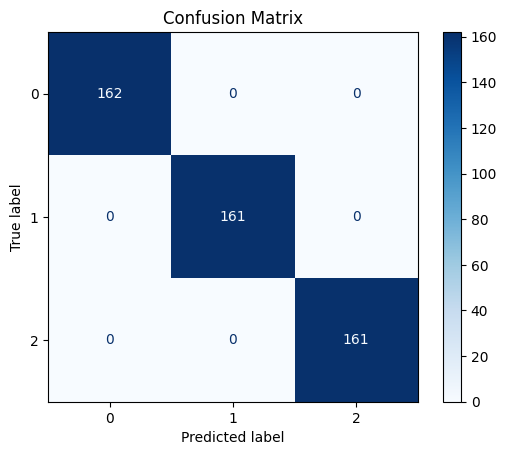

In [ ]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.6311
Precision: 0.6315
Recall: 0.6311
F1 Score: 0.6094

Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.70      0.61        40
           1       0.62      0.32      0.42        41
           2       0.73      0.88      0.80        41

    accuracy                           0.63       122
   macro avg       0.63      0.63      0.61       122
weighted avg       0.63      0.63      0.61       122



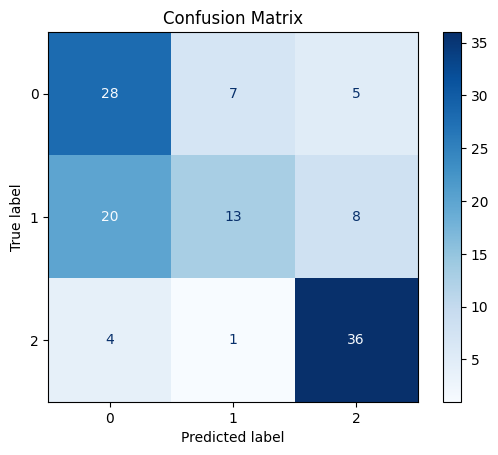

In [ ]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")

<h1>mid features

In [ ]:
print(mid_features.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(mid_features)
X_test = scaler.transform(mid_features_test)
y_train = mid_labels
y_test = mid_labels_test

base_models = {
    "SVM": SVC(probability=True, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

train_meta = []
test_meta = []

for name, model in base_models.items():
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)
    test_pred = model.predict_proba(X_test)
    train_meta.append(train_pred)
    test_meta.append(test_pred)

X_train_meta = np.concatenate(train_meta, axis=1)
X_test_meta = np.concatenate(test_meta, axis=1)

meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_train_meta, y_train)

y_pred = meta_model.predict(X_test_meta)
acc = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy (Mid Features): {acc:.4f}")

Using device: cuda
(484, 100352)
Using device: cuda
Stacked Model Accuracy (Mid Features): 0.7951


In [ ]:
joblib.dump(meta_model, 'meta_model_mid.pkl')

['meta_model_mid.pkl']

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00       161

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484



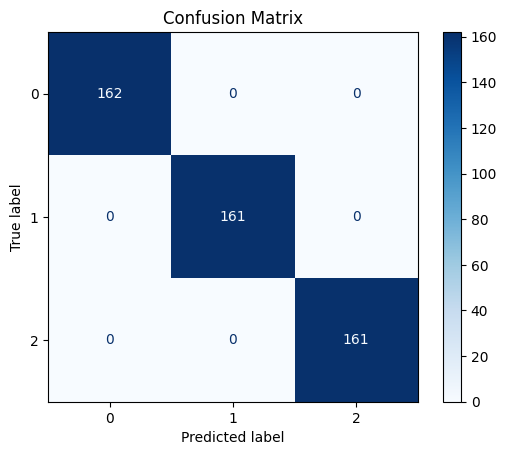

In [ ]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.7951
Precision: 0.7975
Recall: 0.7951
F1 Score: 0.7925

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.85      0.78        40
           1       0.76      0.63      0.69        41
           2       0.90      0.90      0.90        41

    accuracy                           0.80       122
   macro avg       0.80      0.80      0.79       122
weighted avg       0.80      0.80      0.79       122



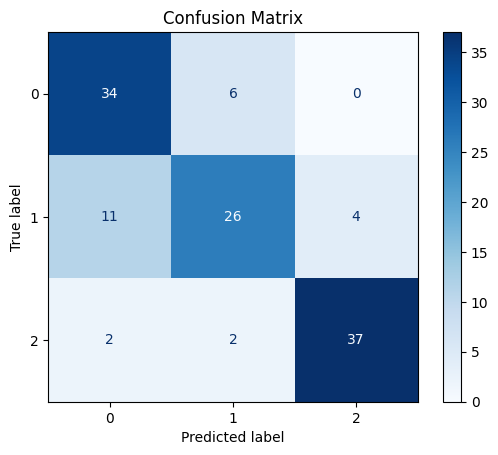

In [ ]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")

<h1>high features<h1>

In [ ]:
print(high_features.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(high_features)
X_test = scaler.transform(high_features_test)
y_train = high_labels
y_test = high_labels_test

base_models = {
    "SVM": SVC(probability=True, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

train_meta = []
test_meta = []

for name, model in base_models.items():
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)
    test_pred = model.predict_proba(X_test)
    train_meta.append(train_pred)
    test_meta.append(test_pred)

X_train_meta = np.concatenate(train_meta, axis=1)
X_test_meta = np.concatenate(test_meta, axis=1)

meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_train_meta, y_train)

y_pred = meta_model.predict(X_test_meta)
acc = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy (Mid Features): {acc:.4f}")

Using device: cuda
(484, 512)
Using device: cuda
Stacked Model Accuracy (Mid Features): 0.9508


In [ ]:
joblib.dump(meta_model, 'meta_model_high.pkl')

['meta_model_high.pkl']

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00       161

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484



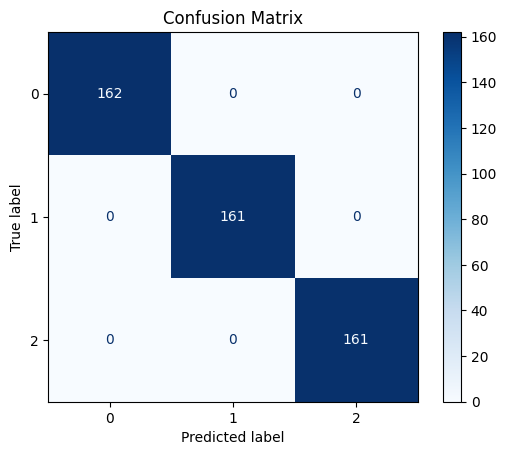

In [ ]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.9508
Precision: 0.9508
Recall: 0.9508
F1 Score: 0.9508

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        40
           1       0.93      0.93      0.93        41
           2       1.00      1.00      1.00        41

    accuracy                           0.95       122
   macro avg       0.95      0.95      0.95       122
weighted avg       0.95      0.95      0.95       122



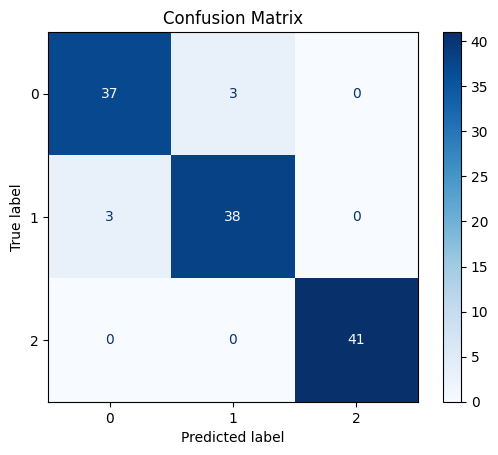

In [ ]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")

<h1>high features with overfit preventing<h1>

In [ ]:
print(high_features.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(high_features)
X_test = scaler.transform(high_features_test)
y_train = high_labels
y_test = high_labels_test
scaler = StandardScaler()
X_train = scaler.fit_transform(high_features)
X_test = scaler.transform(high_features_test)

meta_model, y_pred ,X_test_meta , X_train_meta  = right_way_stacking(X_train, high_labels, X_test, high_labels_test)


Using device: cuda
(484, 512)
Using device: cuda
Stacked Model Accuracy (Right Way): 0.9672


In [ ]:
joblib.dump(meta_model, 'meta_model_high_OP.pkl')

['meta_model_high_OP.pkl']

Accuracy: 0.9669
Precision: 0.9671
Recall: 0.9669
F1 Score: 0.9670

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       162
           1       0.95      0.96      0.95       161
           2       0.99      0.99      0.99       161

    accuracy                           0.97       484
   macro avg       0.97      0.97      0.97       484
weighted avg       0.97      0.97      0.97       484



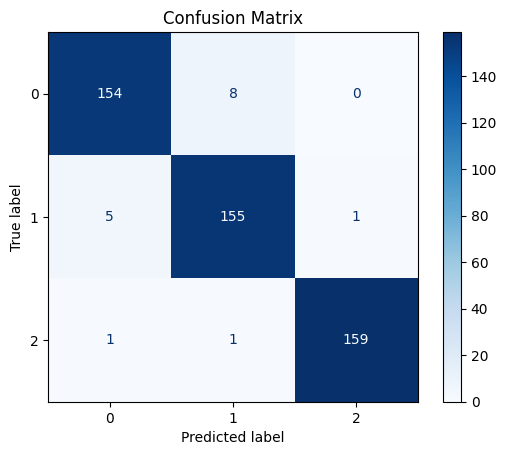

In [ ]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.9672
Precision: 0.9679
Recall: 0.9672
F1 Score: 0.9672

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        40
           1       0.93      0.98      0.95        41
           2       1.00      1.00      1.00        41

    accuracy                           0.97       122
   macro avg       0.97      0.97      0.97       122
weighted avg       0.97      0.97      0.97       122



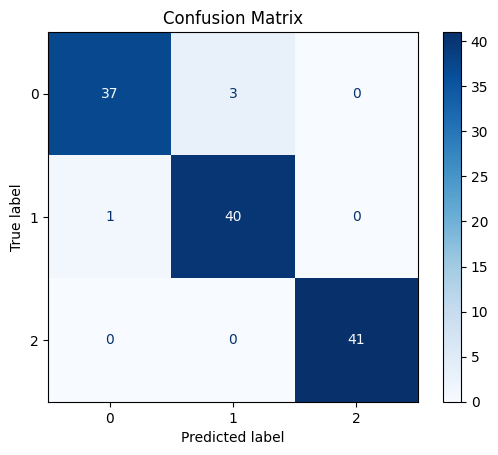

In [ ]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")

<h1>mid features with overfit preventing<h1>

In [ ]:
print(mid_features.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(mid_features)
X_test = scaler.transform(mid_features_test)
y_train = mid_labels
y_test = mid_labels_test
scaler = StandardScaler()
X_train = scaler.fit_transform(mid_features)
X_test = scaler.transform(mid_features_test)

meta_model, y_pred ,X_test_meta , X_train_meta = right_way_stacking(X_train, mid_labels, X_test, mid_labels_test)


Using device: cuda
(484, 100352)
Using device: cuda
Stacked Model Accuracy (Right Way): 0.7787


In [ ]:
joblib.dump(meta_model, 'meta_model_mid_OP.pkl')

['meta_model_mid_OP.pkl']

Accuracy: 0.7686
Precision: 0.7720
Recall: 0.7686
F1 Score: 0.7694

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.78      0.75       162
           1       0.68      0.65      0.67       161
           2       0.92      0.87      0.89       161

    accuracy                           0.77       484
   macro avg       0.77      0.77      0.77       484
weighted avg       0.77      0.77      0.77       484



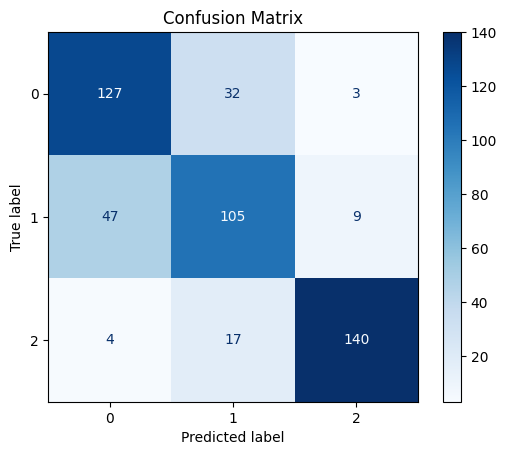

In [ ]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.7787
Precision: 0.7818
Recall: 0.7787
F1 Score: 0.7797

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.78      0.75        40
           1       0.70      0.68      0.69        41
           2       0.92      0.88      0.90        41

    accuracy                           0.78       122
   macro avg       0.78      0.78      0.78       122
weighted avg       0.78      0.78      0.78       122



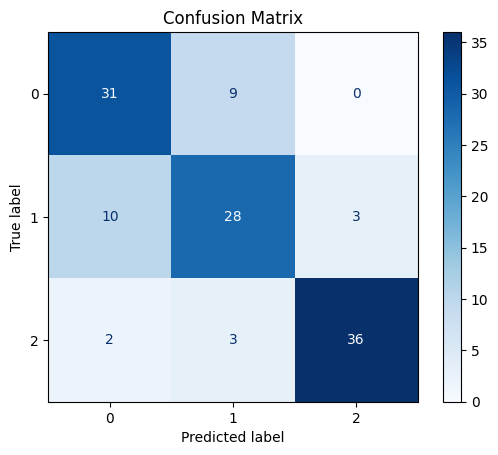

In [ ]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")

<h1>initial features with overfit preventing<h1>

In [11]:
print(initial_features.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(initial_features)
X_test = scaler.transform(initial_features_test)
y_train = initial_labels
y_test = initial_labels_test
scaler = StandardScaler()
X_train = scaler.fit_transform(initial_features)
X_test = scaler.transform(initial_features_test)

meta_model, y_pred ,X_test_meta , X_train_meta = right_way_stacking(X_train, initial_labels, X_test, initial_labels_test,2)


Using device: cuda
(484, 802816)
Using device: cuda
Stacked Model Accuracy (Right Way): 0.6475


In [12]:
joblib.dump(meta_model, 'meta_model_initial_OP.pkl')

['meta_model_initial_OP.pkl']

Accuracy: 0.6033
Precision: 0.5988
Recall: 0.6033
F1 Score: 0.6004

Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.62      0.60       162
           1       0.49      0.44      0.46       161
           2       0.72      0.75      0.73       161

    accuracy                           0.60       484
   macro avg       0.60      0.60      0.60       484
weighted avg       0.60      0.60      0.60       484



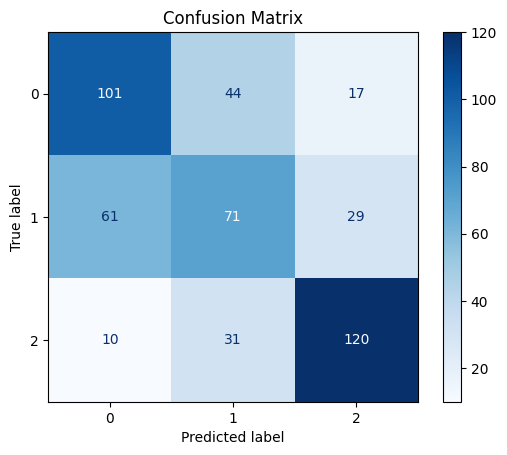

In [13]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.6475
Precision: 0.6385
Recall: 0.6475
F1 Score: 0.6334

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.62      0.60        40
           1       0.61      0.41      0.49        41
           2       0.73      0.90      0.80        41

    accuracy                           0.65       122
   macro avg       0.64      0.65      0.63       122
weighted avg       0.64      0.65      0.63       122



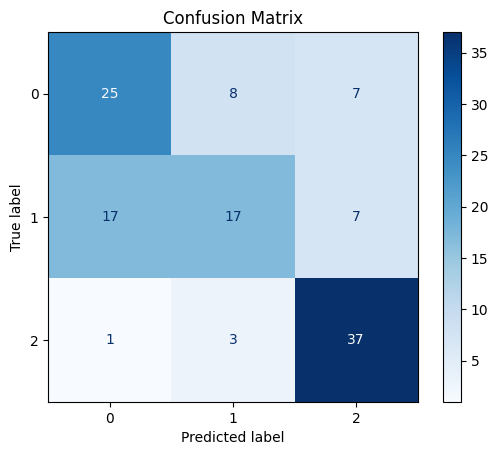

In [14]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")